# **Cross-Lingual Word Embedding Alignment**

**Author:** Pranjal Chaubey (prnjlchaubey@gmail.com)  
*Created using Lightning AI Studio and shared via Colab*

---

## **Overview**
This notebook demonstrates the process of aligning cross-lingual word embeddings using a supervised approach. The task focuses on aligning English and Hindi word embeddings using the **Procrustes method** and evaluates the quality of alignment.

The notebook is organized into three main steps:

---

### **Step 1: Data Preparation**
1. **Loading Pretrained Embeddings**:  
   - Using FastText embeddings, we limit the vocabulary to the top 100,000 words for both languages.
   
2. **Creating Word-Vector Dictionary**:  
   - Construct dictionaries that map the top words to their corresponding word vectors.

3. **Loading Bilingual Dataset**:  
   - Fetching and filtering the **English-Hindi bilingual dataset** from the MUSE repository.

---

### **Step 2: Embedding Alignment**
1. **Procrustes Alignment**:  
   - Performing the Procrustes alignment to align embeddings of the two languages.  
   - Ensuring that the transformation matrix \(W\) is orthogonal.

2. **Visualization**:  
   - Visualizing the word vectors both before and after alignment using **PCA** to observe how well the alignment has adjusted the vectors.

---

### **Step 3: Evaluation**
1. **Training Set Evaluation**:  
   - Calculating **Precision@1** and **Precision@5** using the aligned word embeddings on the training dataset.

2. **Test Set Evaluation**:  
   - Testing the alignment on the MUSE test dataset by calculating **Precision@1** and **Precision@5**.

3. **Qualitative Examples**:  
   - Verifying the alignment results with concrete word pair examples.

---

### **Summary of Results**
- **Precision@1**: 0.309  
- **Precision@5**: 0.617



# Steps for Reproducing the results

Run the below cells in their given order. Change paths whenever required

### Download the english and hindi models from FastText

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz

### Extracting the downloaded models. Create a folder name "Word_Embeddings" before running this cell

In [ ]:
import gzip
import shutil
def extract_gzip(input_file, output_file):
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Extract the models and save it in folder named Word_Embeddings
extract_gzip('cc.en.300.vec.gz', 'Word_Embeddings/cc.en.300.vec')
extract_gzip('cc.hi.300.vec.gz', 'Word_Embeddings/cc.hi.300.vec')

### Download the Bilingual(English-Hindi) dataset from MUSE Github Repo

In [ ]:
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt -P Bilingual_dataset/

### Download Corresponding English-Hindi Test Dataset from same Repo

In [ ]:
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt -P Bilingual_dataset/

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fasttext
import fasttext.util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity



# Step 1: Data Preparation



### Loading model from FastText and extracting Precomputed Embeddings for hindi and english

In [ ]:
# loading hindi and english models. While reproducing the results, make to to change these model path to where you have downloaded the models.
english_model = fasttext.load_model('cc.en.300.bin')
hindi_model = fasttext.load_model('cc.hi.300.bin')

# Example:
print(english_model.get_word_vector("apple"))
print(hindi_model.get_word_vector("सेब"))

[ 1.44060925e-02 -1.85407065e-02  7.78168738e-02  9.62327123e-02
  6.11829162e-02 -6.85825944e-02  1.25941798e-01 -4.56992090e-02
 -7.33104050e-02  5.03169633e-02 -8.20600335e-03 -5.56211993e-02
  5.32698967e-02 -7.81057477e-02  1.74398586e-01  7.17482418e-02
 -1.70824379e-02  5.36853150e-02 -2.10725702e-02  1.60406176e-02
 -9.49636325e-02 -2.47338954e-02  5.45826275e-03  1.18501000e-02
 -1.02901105e-02  6.35251254e-02  1.13734238e-01  2.65568048e-02
 -7.99680129e-02  1.41424417e-01  8.90012011e-02  3.65432501e-02
  6.33940659e-03  9.64735746e-02 -1.29564991e-02  3.49506177e-02
 -3.31422687e-02  7.74207637e-02  1.51700526e-02 -1.51615098e-01
 -4.81646955e-02 -2.98689269e-02 -5.41531220e-02  3.15663107e-02
 -1.33906275e-01  9.74259824e-02  1.13323759e-02  4.80277184e-03
  3.18975598e-02 -9.40478221e-03 -6.07958622e-02 -1.25238776e-01
 -7.48398155e-02  1.12968003e-02 -4.23608907e-02  2.85868701e-02
  1.52979255e-01 -8.28810781e-02 -1.90244764e-02  4.85403789e-03
 -1.11363363e-03  6.79939

### Limiting the vocabulary to top 100000 words in each language

In [ ]:
# Limiting Vocabulary to top 100000 words in both languages
english_words = english_model.get_words()
hindi_words = hindi_model.get_words()

english_words = english_words[:100000]
hindi_words = hindi_words[:100000]

In [ ]:
# creating a dictionary of top words and embeddings
english_vectors_dict_for_top_words = {word: english_model.get_word_vector(word) for word in english_words}
hindi_vectors_dict_for_top_words = {word: hindi_model.get_word_vector(word) for word in hindi_words}

### Loading the bilingual dataset from MUSE Github Repo(Eng-Hin)

In [ ]:
def load_bilingual_lexicon(file_path):
    translation_pairs = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Each line is in the format: english_word hindi_word
            english_word, hindi_word = line.strip().split()
            translation_pairs.append((english_word, hindi_word))
    return translation_pairs


bilingual_lexicon = load_bilingual_lexicon("Bilingual_dataset/en-hi.txt")

In [ ]:
# Function to extract word vectors directly from precomputed top words dictionary
def get_word_vectors_from_dict(vectors_dict, words):
    vectors = []
    for word in words:
        if word in vectors_dict:
            vectors.append(vectors_dict[word])
        else:
            vectors.append(np.zeros(300))
    return np.array(vectors)

In [ ]:
# filtering the english and hindi words from bilinguaL lexicon to make sure that only top 100000 words are included i.e
# words are present in both english_vectors_dict_for_top_words and hindi_vectors_dict_for_top_words.
filtered_bilingual_lexicon = [(en_word, hi_word) for en_word, hi_word in bilingual_lexicon
                              if en_word in english_vectors_dict_for_top_words and hi_word in hindi_vectors_dict_for_top_words]

# Extract the corresponding English and Hindi words after filtering
english_filtered_words = [en_word for en_word, hi_word in filtered_bilingual_lexicon]
hindi_filtered_words = [hi_word for en_word, hi_word in filtered_bilingual_lexicon]

# Getting the word vectors for both languages
english_vectors_for_lexicon = get_word_vectors_from_dict(english_vectors_dict_for_top_words, english_filtered_words)
hindi_vectors_for_lexicon = get_word_vectors_from_dict(hindi_vectors_dict_for_top_words, hindi_filtered_words)

# Checking if both have the same shape
print(english_vectors_for_lexicon.shape)
print(hindi_vectors_for_lexicon.shape)


(18972, 300)
(18972, 300)


# step 2: Embedding Alignment



### Calculating Procrustes Alignment and checking if learned rotation matrix W is orthogonal or not

In [ ]:
def procrustes_align(X_source, X_target):
    A = np.dot(X_source.T, X_target)
    U, _, Vt = np.linalg.svd(A)
    W = np.dot(U, Vt)
    return W

W = procrustes_align(english_vectors_for_lexicon, hindi_vectors_for_lexicon)

#checking if W is orthogonal
def is_orthogonal(W, tolerance=1e-6):
    identity_matrix = np.eye(W.shape[0])
    return np.allclose(np.dot(W, W.T), identity_matrix, atol=tolerance)

print("Is the transformation matrix orthogonal?", is_orthogonal(W))

aligned_english_vectors = np.dot(english_vectors_for_lexicon, W)
aligned_english_vectors.shape

Is the transformation matrix orthogonal? True


(18972, 300)

In [ ]:
similarities = cosine_similarity(aligned_english_vectors, hindi_vectors_for_lexicon)
top_matches = np.argmax(similarities, axis=1)
# Example/checking
for i, idx in enumerate(top_matches[:10]):
    print(f"English word: {english_filtered_words[i]} --> Hindi translation: {hindi_filtered_words[idx]}")

English word: and --> Hindi translation: साथ
English word: was --> Hindi translation: गया
English word: was --> Hindi translation: गया
English word: for --> Hindi translation: लिए
English word: that --> Hindi translation: शायद
English word: that --> Hindi translation: शायद
English word: with --> Hindi translation: साथ
English word: from --> Hindi translation: बाहर
English word: from --> Hindi translation: बाहर
English word: this --> Hindi translation: इस


### Plotting Embedding Before and After Alignment using PCA(Additional)

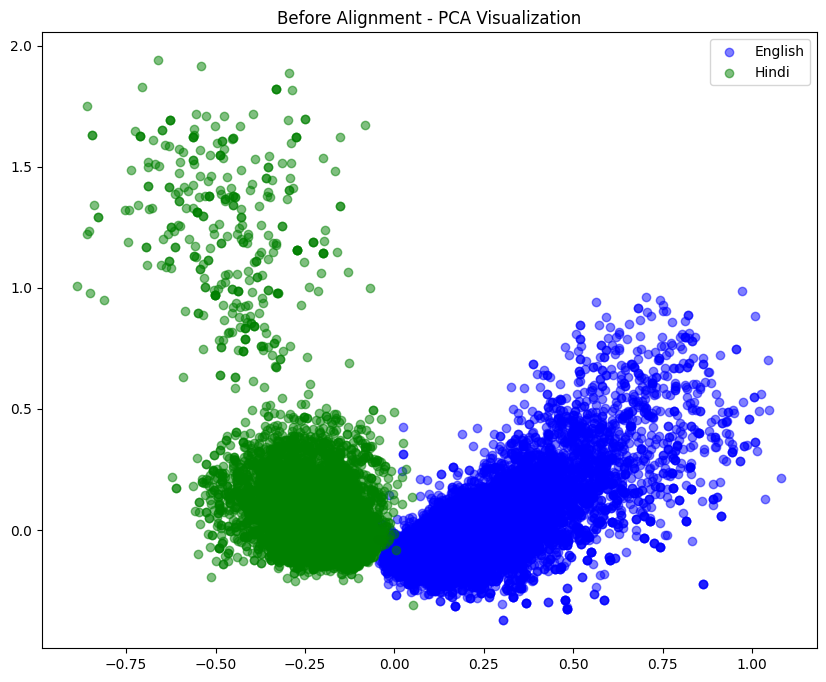

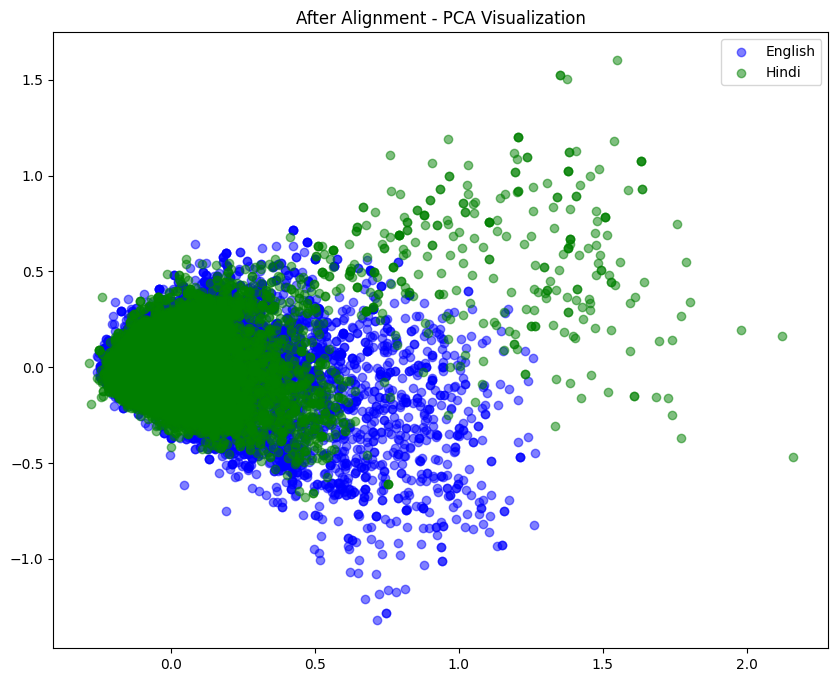

In [ ]:
def plot_embeddings(english_vectors, hindi_vectors, english_words, hindi_words, title):
    reducer = PCA(n_components=2)
    combined_vectors = np.vstack((english_vectors, hindi_vectors))
    reduced_vectors = reducer.fit_transform(combined_vectors)
    reduced_english = reduced_vectors[:len(english_vectors)]
    reduced_hindi = reduced_vectors[len(english_vectors):]

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_english[:, 0], reduced_english[:, 1], color='blue', label='English', alpha=0.5)
    plt.scatter(reduced_hindi[:, 0], reduced_hindi[:, 1], color='green', label='Hindi', alpha=0.5)
    plt.title(f"{title} - {method} Visualization")
    plt.legend(loc='best')
    plt.show()

# Before Alignment
plot_embeddings(english_vectors_for_lexicon, hindi_vectors_for_lexicon, english_filtered_words, hindi_filtered_words, "Before Alignment", method='PCA')

# After alignment
plot_embeddings(aligned_english_vectors, hindi_vectors_for_lexicon, english_filtered_words, hindi_filtered_words, "After Alignment", method='PCA')


# Step 3: Evaluation:

### Calculating Precision@1 and Precision@5

In [ ]:
def precision_at_k(similarities, true_indices, k):
    top_k_matches = np.argsort(similarities, axis=1)[:, -k:]
    hits = sum([1 if true_index in top_k_matches[i] else 0 for i, true_index in enumerate(true_indices)])
    return hits / len(true_indices)

true_indices = [hindi_filtered_words.index(hi_word) for _, hi_word in filtered_bilingual_lexicon]


precision_1 = precision_at_k(similarities, true_indices, 1)
precision_5 = precision_at_k(similarities, true_indices, 5)

print(f"Precision@1: {precision_1}")
print(f"Precision@5: {precision_5}")

Precision@1: 0.2803078220535526
Precision@5: 0.5853889943074004


### Performing word translation from English to Hindi using the aligned embeddings.

In [ ]:
def translate_word(word, english_model, hindi_words, hindi_vectors, W, top_n=1):
    english_vector = english_model.get_word_vector(word)
    aligned_vector = np.dot(english_vector, W)
    similarities = cosine_similarity([aligned_vector], hindi_vectors)[0]
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    top_translations = [hindi_words[i] for i in top_indices]
    return top_translations
top_words_to_translate = ['and', 'was', 'for', 'that', 'with', 'from', 'this']

for word in top_words_to_translate:
    translations = translate_word(word, english_model, hindi_filtered_words, hindi_vectors_for_lexicon, W, top_n=1)
    print(f"English word: {word} --> Hindi translation: {translations[0]}")


English word: and --> Hindi translation: साथ
English word: was --> Hindi translation: गया
English word: for --> Hindi translation: लिए
English word: that --> Hindi translation: शायद
English word: with --> Hindi translation: साथ
English word: from --> Hindi translation: बाहर
English word: this --> Hindi translation: इस


In [ ]:
top_words_to_translate = ['he', 'she', 'them', 'you', 'love', 'hate'] # Change words in list if you want translation for other words.
for word in top_words_to_translate:
    translations = translate_word(word, english_model, hindi_filtered_words, hindi_vectors_for_lexicon, W, top_n=1)
    print(f"English word: {word} --> Hindi translation: {translations[0]}")

### Evaluating the translation accuracy using the MUSE test dictionary.


In [ ]:
with open('/teamspace/studios/this_studio/dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt', 'r') as f:
    muse_test_pairs = [line.strip().split() for line in f]

# Filtering test pairs to retain only those present in the vocabularies
valid_test_pairs = [(en_word, hi_word) for en_word, hi_word in muse_test_pairs
                    if en_word in english_filtered_words and hi_word in hindi_filtered_words]

true_indices = [hindi_filtered_words.index(hi_word) for _, hi_word in valid_test_pairs]
english_test_indices = [english_filtered_words.index(en_word) for en_word, _ in valid_test_pairs]
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(aligned_english_vectors[english_test_indices], hindi_vectors_for_lexicon)

# true_indices: Indices of correct Hindi translations in the test dictionary
# similarities: Precomputed similarities between English and Hindi embeddings
precision_1 = precision_at_k(similarities, true_indices, 1)
precision_5 = precision_at_k(similarities, true_indices, 5)

print(f"Precision@1: {precision_1}")
print(f"Precision@5: {precision_5}")

Precision@1: 0.309375
Precision@5: 0.616875
